<a href="https://colab.research.google.com/github/adirsonmfjr/credito-rural/blob/main/Artigo_02_Cru_Geral%20(18-03-2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import requests
import pandas as pd
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# URL do novo arquivo no GitHub
url = "https://raw.githubusercontent.com/adirsonmfjr/credito-rural/main/Dados_Estoque_credito_rural_1993-2023.xls"

# Baixar o arquivo
response = requests.get(url)

if response.status_code == 200:
    # Carregar o Excel com ajustes
    df = pd.read_excel(
        BytesIO(response.content),
        sheet_name="Séries",  # Nome da aba no Excel
        engine="xlrd",
        dtype=str  # Lê como string para evitar conversões erradas
    )

    # Converter colunas numéricas para float e substituir NaN por 0
    for col in df.columns[3:]:  # Pular as três primeiras colunas (Sigla, Código, Município)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    print("Arquivo carregado com sucesso!")

else:
    print("Erro ao baixar o arquivo:", response.status_code)

# Configurar pandas para exibir valores sem notação científica
pd.set_option('display.float_format', '{:,.0f}'.format)

# Exibir as primeiras linhas para verificar se faz sentido
df.head()


Arquivo carregado com sucesso!


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,20776771,8562961,11362390,11235470,14613649,15877934,9088736,8996591,6580221,4908745
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,3197656,35660,334018,5179684,1636721,924183,297710,524263,112330,151097
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,8906259,9917391,16527385,13863737,11236307,10363271,7850346,3423072,3098155,3913477
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,16035479,18792652,9158576,10670679,17666324,14845991,6806347,9281610,4009833,3910707
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,4519761,3421325,4075607,3578121,11337150,6119740,3826153,2452279,6232797,3550908


# Parte 2 - Cálculo das Métricas RFM

In [35]:
import pandas as pd

# Supondo que df já esteja carregado

# Identificar as colunas de anos (ignorar colunas categóricas)
colunas_anos = [col for col in df.columns if col.isdigit()]  # Filtra apenas colunas com nome numérico

# Criar colunas de Data Inicial e Data Final
df["Data_Inicial"] = int(min(colunas_anos))  # Primeiro ano disponível na base
df["Data_Final"] = int(max(colunas_anos))    # Último ano disponível na base

# Função para calcular a Recência (R), garantindo que não seja zero
def calcular_recencia(row):
    anos_com_estoque = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com estoque positivo
    if anos_com_estoque:
        return max(1, df["Data_Final"].iloc[0] - max(anos_com_estoque))  # Último ano com estoque - Data Final (mínimo 1)
    return max(1, df["Data_Final"].iloc[0] - df["Data_Inicial"].iloc[0])  # Caso não haja estoque em nenhum ano

# Aplicar a função de Recência
df["Recencia"] = df.apply(calcular_recencia, axis=1)

# Criar a coluna de Frequência (F) - Contagem de anos com estoque positivo
df["Frequencia"] = (df[colunas_anos] > 0).sum(axis=1)

# Criar a coluna Monetário (M) - Soma total dos estoques ao longo do período
df["Monetario"] = df[colunas_anos].sum(axis=1)

# Criar a coluna de Longevidade (L) como o intervalo entre o primeiro e o último ano com crédito
def calcular_longevidade(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com crédito positivo
    if anos_validos:
        return max(anos_validos) - min(anos_validos)  # Último ano - Primeiro ano
    return 0  # Caso nunca tenha pego crédito

# Aplicar a função para calcular Longevidade
df["Longevidade"] = df.apply(calcular_longevidade, axis=1)

# Salvar o DataFrame no Colab
df.to_csv("/content/df_rfm.csv", index=False)

# Exibir as métricas RFM e Longevidade
df[["Recencia", "Frequencia", "Monetario", "Longevidade"]].head(15)

,Recencia,Frequencia,Monetario,Longevidade
0,1,29,231741082,28
1,1,29,41216925,30
2,1,31,177560391,30
3,1,29,257391191,28
4,1,26,98085601,26
5,1,31,73294608,30
6,1,26,62018956,26
7,1,30,64958872,30
8,1,14,1310817,23
9,1,25,17574727,24


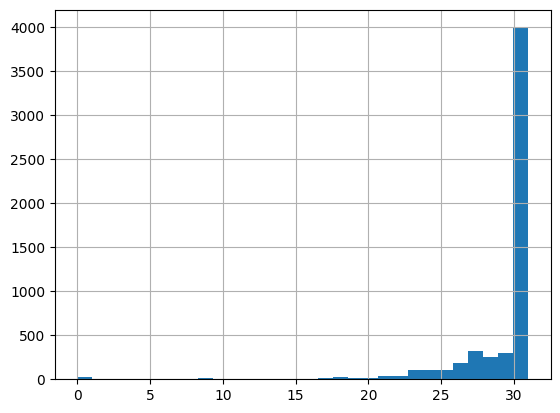

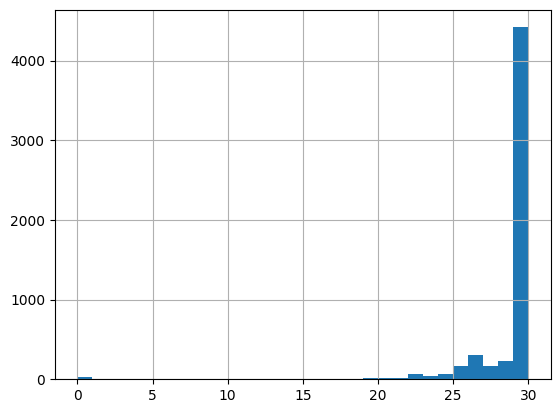

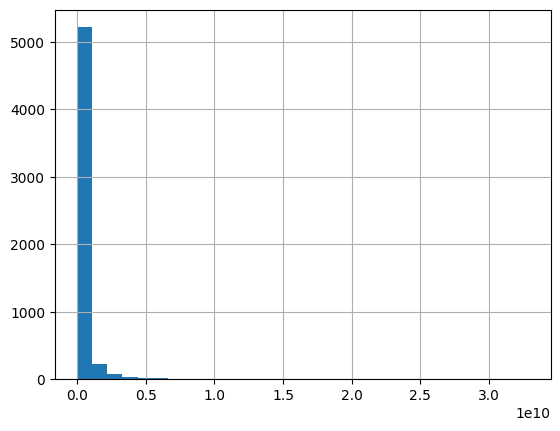

In [36]:
import matplotlib.pyplot as plt
df['Frequencia'].hist(bins=30)
plt.show()

import matplotlib.pyplot as plt
df['Longevidade'].hist(bins=30)
plt.show()

import matplotlib.pyplot as plt
df['Monetario'].hist(bins=30)
plt.show()


In [69]:
import pandas as pd

# Carregar o DataFrame salvo anteriormente
df = pd.read_csv("/content/df_rfm.csv")

# Função para criar quintis corretamente sem adicionar ruído
def criar_quintis(column, invert=False):
    unique_values = column.nunique()

    # Se houver poucos valores únicos, usa pd.cut()
    if unique_values < 5:
        if invert:
            return pd.cut(column.rank(method='first', ascending=False), bins=unique_values, labels=range(5, 5 - unique_values, -1)).astype(int)
        return pd.cut(column.rank(method='first'), bins=unique_values, labels=range(1, unique_values + 1)).astype(int)

    # Se houver valores suficientes, usa rank() antes de pd.qcut()
    ranked_column = column.rank(method="first")

    if invert:
        return pd.qcut(ranked_column, q=5, labels=[5, 4, 3, 2, 1], duplicates="drop").astype(int)
    return pd.qcut(ranked_column, q=5, labels=[1, 2, 3, 4, 5], duplicates="drop").astype(int)

# Criar escores por quintil para RFM e Longevidade
df["Recencia_Score"] = criar_quintis(df["Recencia"], invert=True)
df["Frequencia_Score"] = criar_quintis(df["Frequencia"])
df["Monetario_Score"] = criar_quintis(df["Monetario"])
df["Longevidade_Score"] = criar_quintis(df["Longevidade"])

# Salvar o DataFrame atualizado
df.to_csv("/content/df_rfm_scores.csv", index=False)

# Exibir as métricas RFM, Longevidade e escores
df[["Recencia", "Frequencia", "Monetario", "Longevidade", "Recencia_Score", "Frequencia_Score", "Monetario_Score", "Longevidade_Score"]].head(15)


,Recencia,Frequencia,Monetario,Longevidade,Recencia_Score,Frequencia_Score,Monetario_Score,Longevidade_Score
0,1,29,231741082,28,5,2,4,1
1,1,29,41216925,30,5,2,2,2
2,1,31,177560391,30,5,2,4,2
3,1,29,257391191,28,5,2,4,1
4,1,26,98085601,26,5,1,3,1
5,1,31,73294608,30,5,2,3,2
6,1,26,62018956,26,5,1,3,1
7,1,30,64958872,30,5,2,3,2
8,1,14,1310817,23,5,1,1,1
9,1,25,17574727,24,5,1,1,1


In [61]:
import pandas as pd

# 1) Carregue o DataFrame que já possui:
df = pd.read_csv("/content/df_rfm_scores.csv")

# 2) Criar a média de Frequência e Longevidade com valores float
df["F_L_Media"] = (df["Frequencia_Score"] + df["Longevidade_Score"]) / 2

# 3) Calcular o score final ponderado
df["Weighted_Score"] = (
      0.50 * df["F_L_Media"]  # Média de F + L
    + 0.50 * df["Monetario_Score"]
)

# 4) Classificar usando as novas faixas:
#    0 = "Sem classificação"
#    (0, 1] = "Baixa"
#    (1, 2] = "Média-baixa"
#    (2, 3] = "Média"
#    (3, 4] = "Média-alta"
#    (4, 5] = "Alta"
df["Weighted_Label"] = pd.cut(
    df["Weighted_Score"],
    bins=[-0.1, 0, 1, 2, 3, 4, 5],   # Incluí -0.1 para garantir que 0 seja capturado corretamente
    labels=["Sem classificação", "Baixa", "Média-baixa", "Média", "Média-alta", "Alta"],
    include_lowest=True
)

# 5) Garantir pelo menos uma casa decimal na exibição dos números
df["F_L_Media"] = df["F_L_Media"].map(lambda x: f"{x:.1f}")  # Formata com pelo menos 1 casa decimal
df["Weighted_Score"] = df["Weighted_Score"].map(lambda x: f"{x:.1f}")  # Formata com pelo menos 1 casa decimal

# Exibir as colunas relevantes
display(df[[
    "Frequencia_Score",
    "Longevidade_Score",
    "F_L_Media",  # Agora formatado corretamente
    "Monetario_Score",
    "Weighted_Score",
    "Weighted_Label"
]].head(15))

# Se quiser salvar o DataFrame final:
df.to_csv("/content/df_rfm_scores_weighted.csv", index=False)


,Frequencia_Score,Longevidade_Score,F_L_Media,Monetario_Score,Weighted_Score,Weighted_Label
0,2,1,1.5,4,2.8,Média
1,2,2,2.0,2,2.0,Média-baixa
2,2,2,2.0,4,3.0,Média
3,2,1,1.5,4,2.8,Média
4,1,1,1.0,3,2.0,Média-baixa
5,2,2,2.0,3,2.5,Média
6,1,1,1.0,3,2.0,Média-baixa
7,2,2,2.0,3,2.5,Média
8,1,1,1.0,1,1.0,Baixa
9,1,1,1.0,1,1.0,Baixa


Distribuição do Weighted_Label:


,count
Weighted_Label,
Alta,1143
Baixa,509
Média,1505
Média-alta,1394
Média-baixa,1045


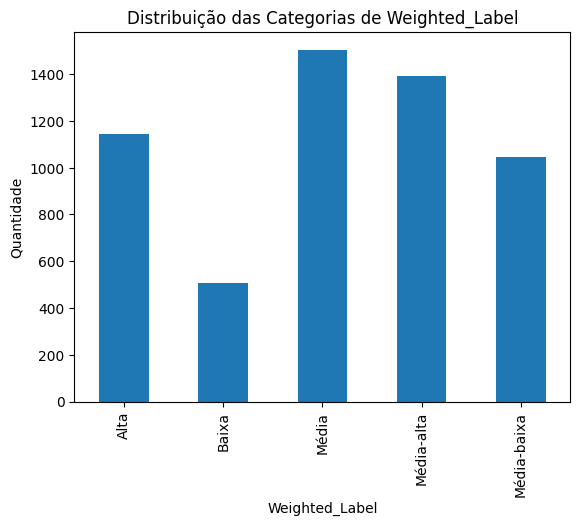

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Carregar o DataFrame final com Weighted_Label (já contém "Weighted_Score" e "Weighted_Label")
df = pd.read_csv("/content/df_rfm_scores_weighted.csv")

# 2) Criar uma tabela com a contagem de cada categoria
count_table = df["Weighted_Label"].value_counts().sort_index()

# 3) Exibir a tabela
print("Distribuição do Weighted_Label:")
display(count_table)

# 4) Plotar um gráfico de barras
count_table.plot(kind='bar')
plt.xlabel("Weighted_Label")
plt.ylabel("Quantidade")
plt.title("Distribuição das Categorias de Weighted_Label")
plt.show()


In [56]:
df.describe()

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,Recencia,Frequencia,Monetario,Longevidade,Recencia_Score,Frequencia_Score,Monetario_Score,Longevidade_Score,F_L_Media,Weighted_Score
count,"5,596","5,596","5,596","5,596","5,596","5,596","5,596","5,596","5,596","5,596",...,"5,596","5,596","5,596","5,596","5,596","5,596","5,596","5,596","5,596","5,596"
mean,"11,547,744","12,215,312","4,246,835","3,460,809","5,306,076","5,295,413","5,006,359","5,728,788","6,884,897","7,617,159",...,1,29,"349,109,121",29,3,3,3,3,3,3
std,"73,419,689","44,085,829","16,400,953","9,014,824","16,528,791","16,712,394","16,230,825","17,517,802","24,637,671","27,363,073",...,2,4,"987,091,513",3,1,1,1,1,1,1
min,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
25%,"3,766","3,764","44,224","93,224","196,256","344,734","244,633","185,185","201,024","251,717",...,1,29,"29,234,823",29,2,2,2,2,2,2
50%,"568,006","814,676","779,829","850,848","1,190,008","1,390,628","1,145,745","1,063,274","1,198,805","1,385,082",...,1,31,"94,710,170",30,3,3,3,3,3,3
75%,"4,252,538","6,214,519","3,496,582","3,208,503","4,341,466","4,520,183","4,074,770","4,399,161","5,024,152","5,697,155",...,1,31,"298,617,448",30,4,4,4,4,4,4
max,"4,129,727,420","955,976,181","935,340,684","216,727,149","688,617,790","549,495,135","497,872,260","443,763,639","822,587,587","1,049,674,643",...,30,31,"32,898,505,927",30,5,5,5,5,5,5


In [60]:
print(df.columns)

Index(['Sigla', 'Codigo', 'Município', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023',
       'Data_Inicial', 'Data_Final', 'Recencia', 'Frequencia', 'Monetario',
       'Longevidade', 'Recencia_Score', 'Frequencia_Score', 'Monetario_Score',
       'Longevidade_Score', 'F_L_Media', 'Weighted_Score', 'Weighted_Label'],
      dtype='object')


In [66]:
df.head()

,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,Frequencia,Monetario,Longevidade,Recencia_Score,Frequencia_Score,Monetario_Score,Longevidade_Score,F_L_Media,Weighted_Score,Weighted_Label
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,29,231741082,28,5,2,4,1,2,3,Média
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,29,41216925,30,5,2,2,2,2,2,Média-baixa
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,31,177560391,30,5,2,4,2,2,3,Média
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,29,257391191,28,5,2,4,1,2,3,Média
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,26,98085601,26,5,1,3,1,1,2,Média-baixa


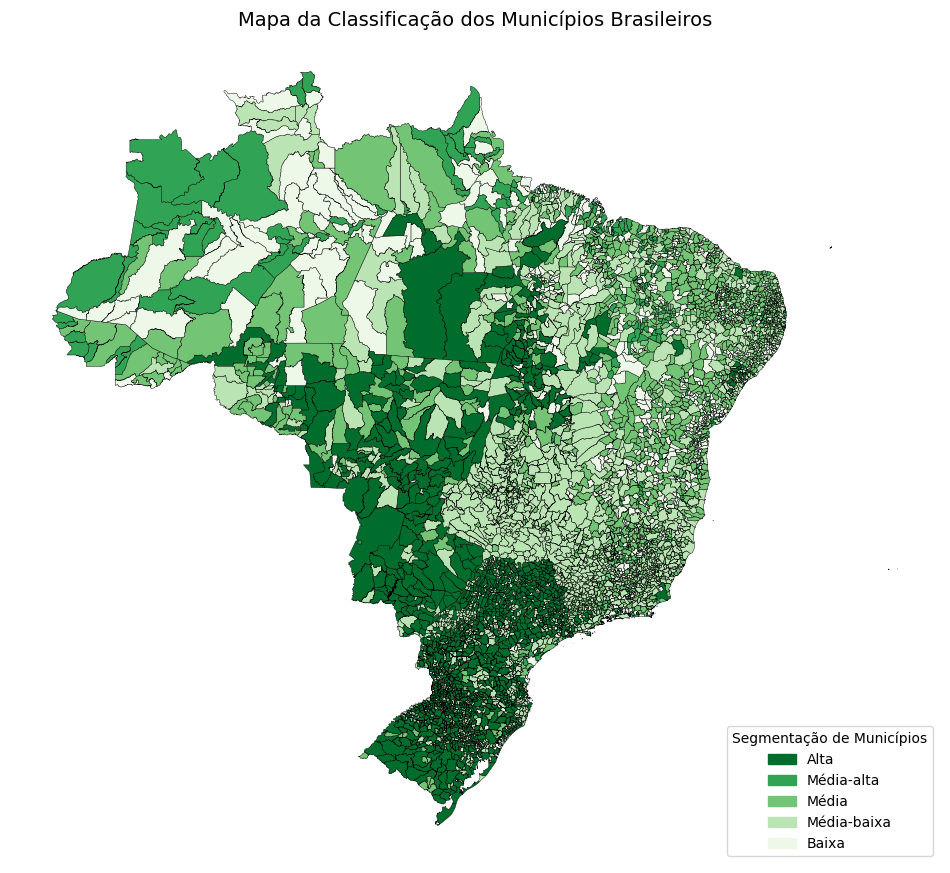

In [67]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches  # Para criar a legenda manualmente

# 1. Carregar o shapefile
shapefile_path = "/content/BR_Municipios_2023.shp"
gdf = gpd.read_file(shapefile_path)

# 2. Carregar o CSV
df = pd.read_csv("/content/df_rfm_scores_weighted.csv")

# 3. Converter os códigos para string e garantir que têm o mesmo formato
gdf["CD_MUN"] = gdf["CD_MUN"].astype(str).str.zfill(7)  # Garante 7 dígitos
df["Codigo"] = df["Codigo"].astype(str).str.zfill(7)  # Garante 7 dígitos

# 4. Agora o merge deve funcionar corretamente
gdf = gdf.merge(df, left_on="CD_MUN", right_on="Codigo", how="left")

# 5. Definir cores para as categorias
cores_credito = {
    "Alta": "#006d2c",
    "Média-alta": "#31a354",
    "Média": "#74c476",
    "Média-baixa": "#bae4b3",
    "Baixa": "#edf8e9",
}

# 6. Criar o mapa
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(column="Weighted_Label",
         cmap=mcolors.ListedColormap(cores_credito.values()),
         linewidth=0.3, edgecolor="black", legend=False, ax=ax)

# 7. Criar legenda manualmente e posicioná-la no canto inferior direito
patches = [mpatches.Patch(color=cor, label=label) for label, cor in cores_credito.items()]
ax.legend(handles=patches, title="Segmentação de Municípios", loc="lower right", fontsize=10)

# 8. Configurações do mapa
ax.set_title("Mapa da Classificação dos Municípios Brasileiros", fontsize=14)
plt.axis("off")  # Remove os eixos
plt.show()


In [ ]:
plt.figure(figsize=(8, 8))
rfm_filtrado["classificacao_LFM"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Proporção de Clientes por Segmento (Sem 'Outros Clientes')")
plt.ylabel("")
plt.show()
